### CNN on CIFR Assignment:

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use DropOut layers.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

# 1. Importing Required Packages

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Lambda

In [ ]:
tf.keras.backend.clear_session()


# 2. Loaing CIFAR10 Data

In [ ]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]



In [ ]:
print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


## 2.1 Prepocessing Data

### 2.1.1 One Hot Encoding

In [ ]:
# convert to one hot encoing 
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

### 2.1.2 Data Augmentation

In [ ]:
#https://keras.io/api/preprocessing/image/
from keras.preprocessing.image import ImageDataGenerator
datagen_train = ImageDataGenerator(
    rescale=1./255, #rescaling [0,1]       
    rotation_range=15,
    width_shift_range=0.4, #shift the image to the left or right horzontaly
    height_shift_range=0.4,# shift vertically
    shear_range=0.2,
    zoom_range=0.2, 
    horizontal_flip=True, #Randomly flip inputs horizontally.
    fill_mode='nearest', #filling the area
)


datagen_train.fit(X_train)




In [ ]:
#scaling test data to lie between [0,1] #no augmenation for test_data.
X_test = X_test.astype('float32')
X_test /= 255

# 3 . Blocks of DENSE NET

In [ ]:
# Hyperparameters
#batch_size = 256
#epochs = 300
l = 12
num_filter = 12
compression = 0.5
dropout_rate = 0

# Dense Block
def denseblock(input, num_filter , dropout_rate = 0): #setting drop_rate = 0; we don't want dropouts
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same',kernel_initializer='he_uniform')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter , dropout_rate = 0):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same',kernel_initializer='he_uniform')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

## 3.1 Model with DENSE NET

In [ ]:
def DCNN():
  num_filter = 36
  input = layers.Input(shape=(img_height, img_width, channel))
  First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same',kernel_initializer='he_uniform')(input)
  
  First_Block = denseblock(First_Conv2D, num_filter)
  First_Transition = transition(First_Block, num_filter)

  Second_Block = denseblock(First_Transition, num_filter)
  Second_Transition = transition(Second_Block, num_filter)

  Third_Block = denseblock(Second_Transition, num_filter)
  Third_Transition = transition(Third_Block, num_filter)

  Last_Block = denseblock(Third_Transition,  num_filter)
  output = output_layer(Last_Block)

  model = Model(inputs=[input], outputs=[output])

  return model

In [ ]:
model = DCNN()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 36)   972         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 36)   144         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 36)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## 3.2 Training the Model Stage -1

In [ ]:
from tensorflow.keras.callbacks import  ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard, EarlyStopping

def Train_first_time():
  batch = 64  #batch = 64, total files = 50k, so in each epoch 391 data points is seen by my model. 50k/64 = floor(390.625)=781
  epochs = 100 #max_epoch set to be 300 and using earlystopping if incase we dont need 300 epoch to converge

  opt = tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.01,
    epsilon=1e-07,
    centered=True,
    name="RMSprop",
)
  metrics = ["acc", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()] #sice its clasification 
                                                                             #using recall and Precsion 
  model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics) 
  callbacks = [
        ModelCheckpoint("./model.h5",monitor = 'val_acc',save_best_only=True),
        ReduceLROnPlateau(monitor='val_acc', factor=0.6,mode='max', patience=5), #Reducing learing rate by factor of(0.5),
                                                                       # new_lr = lr * factor.
        CSVLogger("./data.csv"),
        TensorBoard(),
        EarlyStopping(monitor='val_acc', patience=15,mode= 'max',restore_best_weights=True) #stop traing is val_loss does not change
    ]                                                                             #after 20 epochs.
  history = model.fit(datagen_train.flow(X_train,y_train,batch_size=batch),steps_per_epoch = len(X_train) / 64,
        validation_data=(X_test,y_test),
        epochs=epochs,
        callbacks=callbacks)
  tf.keras.models.save_model(model,'./model_1.h5')
  
  
  return history


In [ ]:
import sys
if __name__ == '__main__':
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    sess = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(sess)

    if len(sys.argv) > 1:
        gpu = sys.argv[1]
    device = '/device:GPU:0'   #using Gpu for paced training

    with tf.device(device):
        history_1 = Train_first_time()

Epoch 1/100
781/781 [==============================] - 79s 92ms/step - loss: 2.0073 - acc: 0.2662 - recall: 0.0448 - precision: 0.4056 - val_loss: 1.7024 - val_acc: 0.4004 - val_recall: 0.2560 - val_precision: 0.5818
Epoch 2/100
781/781 [==============================] - 69s 88ms/step - loss: 1.5352 - acc: 0.4373 - recall: 0.2189 - precision: 0.6370 - val_loss: 1.6887 - val_acc: 0.4689 - val_recall: 0.3840 - val_precision: 0.5321
Epoch 3/100
781/781 [==============================] - 69s 88ms/step - loss: 1.3243 - acc: 0.5261 - recall: 0.3459 - precision: 0.7007 - val_loss: 2.1188 - val_acc: 0.4442 - val_recall: 0.4044 - val_precision: 0.4929
Epoch 4/100
781/781 [==============================] - 69s 88ms/step - loss: 1.1673 - acc: 0.5838 - recall: 0.4297 - precision: 0.7305 - val_loss: 1.1840 - val_acc: 0.6169 - val_recall: 0.5312 - val_precision: 0.7088
Epoch 5/100
781/781 [==============================] - 69s 88ms/step - loss: 1.0531 - acc: 0.6241 - recall: 0.4958 - precision: 0.75

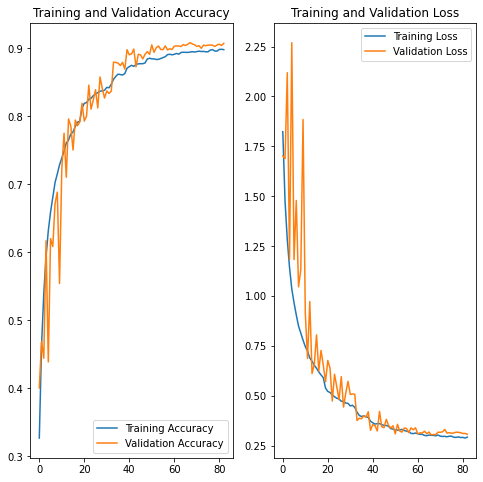

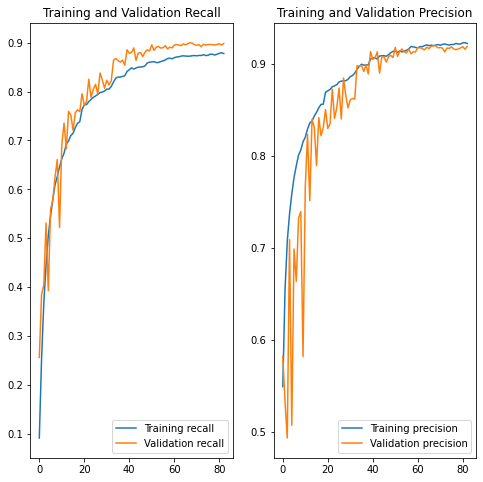

In [ ]:
import matplotlib.pyplot as plt
epochs =83
acc = history_1.history['acc']
val_acc = history_1.history['val_acc']

loss=history_1.history['loss']
val_loss=history_1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
acc = history_1.history['recall']
val_acc = history_1.history['val_recall']

loss=history_1.history['precision']
val_loss=history_1.history['val_precision']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training recall')
plt.plot(epochs_range, val_acc, label='Validation recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training precision')
plt.plot(epochs_range, val_loss, label='Validation precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')
plt.show()

## 3.3 Traing the Saved model Stage-2

In [ ]:
#Loading the model
tf.keras.backend.clear_session()


half_trained_model = tf.keras.models.load_model("./model_1.h5")

In [ ]:
from tensorflow.keras.callbacks import  ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard, EarlyStopping

def Train_second():
  batch = 64  #batch = 128, total files = 50k, so in each epoch 391 data points is seen by my model. 50k/64 
             # = floor(781.25)=781
  epochs = 100 #max_epoch set to be 300 and using earlystopping if incase we dont need 300 epoch to converge

  opt = tf.keras.optimizers.RMSprop(
    learning_rate=0.0001,
    rho=0.9,
    momentum=0.1,
    epsilon=1e-07,
    centered=True,
    name="RMSprop",
)
  metrics = ["acc", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()] #sice its clasification 
                                                                             #using recall and Precsion 
  half_trained_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics) 
  callbacks = [
        ModelCheckpoint("./model_2.h5",monitor = 'val_acc',save_best_only=True),
        ReduceLROnPlateau(monitor='val_acc', factor=0.6,mode='max', patience=1), #Reducing learing rate by factor of(0.5),
                                                                       # new_lr = lr * factor.
        CSVLogger("./data.csv"),
        TensorBoard(),
        EarlyStopping(monitor='val_acc', patience=5,mode= 'max',restore_best_weights=True) #stop traing is val_loss does not change
    ]                                                                             #after 20 epochs.
  history = half_trained_model.fit(datagen_train.flow(X_train,y_train,batch_size=batch),steps_per_epoch = len(X_train) / 64,
        validation_data=(X_test,y_test),
        epochs=epochs,
        callbacks=callbacks)
  tf.keras.models.save_model(half_trained_model,'./model_2.h5')
  
  
  return history


In [ ]:
if __name__ == '__main__':
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    sess = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(sess)

    if len(sys.argv) > 1:
        gpu = sys.argv[1]
    device = '/device:GPU:0'   #using Gpu for paced training

    with tf.device(device):
        history_2 = Train_second()

Epoch 1/100
781/781 [==============================] - 70s 83ms/step - loss: 0.1407 - acc: 0.9514 - recall: 0.9435 - precision: 0.9607 - val_loss: 0.2482 - val_acc: 0.9208 - val_recall: 0.9126 - val_precision: 0.9317
Epoch 2/100
781/781 [==============================] - 62s 80ms/step - loss: 0.1043 - acc: 0.9632 - recall: 0.9580 - precision: 0.9698 - val_loss: 0.2612 - val_acc: 0.9198 - val_recall: 0.9127 - val_precision: 0.9286
Epoch 3/100
781/781 [==============================] - 62s 80ms/step - loss: 0.0848 - acc: 0.9712 - recall: 0.9667 - precision: 0.9756 - val_loss: 0.2570 - val_acc: 0.9215 - val_recall: 0.9165 - val_precision: 0.9300
Epoch 4/100
781/781 [==============================] - 62s 80ms/step - loss: 0.0759 - acc: 0.9741 - recall: 0.9710 - precision: 0.9789 - val_loss: 0.2713 - val_acc: 0.9198 - val_recall: 0.9151 - val_precision: 0.9285
Epoch 5/100
781/781 [==============================] - 62s 80ms/step - loss: 0.0655 - acc: 0.9773 - recall: 0.9747 - precision: 0.98

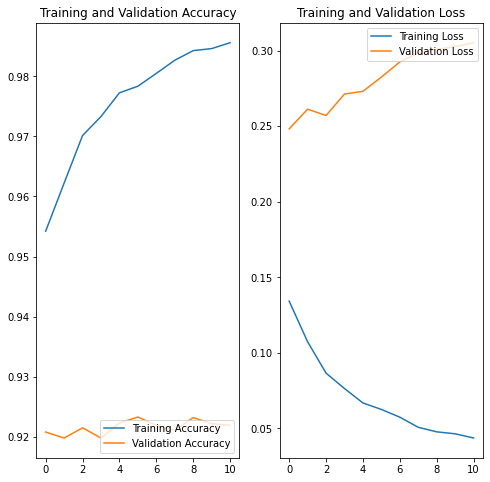

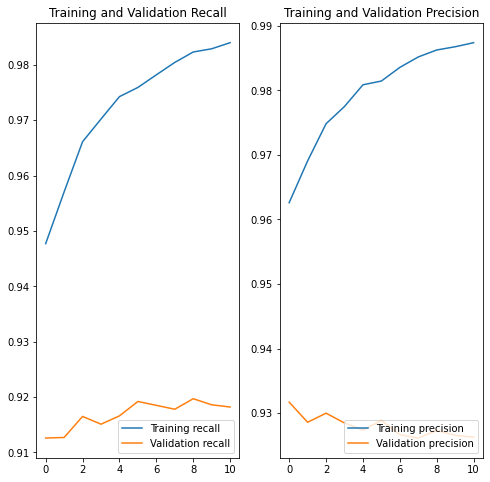

In [ ]:
import matplotlib.pyplot as plt
epochs =11
acc = history_2.history['acc']
val_acc = history_2.history['val_acc']

loss=history_2.history['loss']
val_loss=history_2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
acc = history_2.history['recall']
val_acc = history_2.history['val_recall']

loss=history_2.history['precision']
val_loss=history_2.history['val_precision']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training recall')
plt.plot(epochs_range, val_acc, label='Validation recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training precision')
plt.plot(epochs_range, val_loss, label='Validation precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')
plt.show()

In [ ]:
tf.keras.utils.plot_model(
    half_trained_model,
    to_file="model.png",
    show_shapes=True,
    dpi=96,
)

# 4. Result

In [ ]:
#https://pypi.org/project/prettytable/
from prettytable import PrettyTable

result= PrettyTable()
result.field_names = [ "Model-Stage",'Epochs','train_loss_%','test_loss_%','train_acc_%','test_acc_%']

result.add_row(["Stage-1", 83, round(0.3022*100,2), round(0.3069*100,2), round(0.8957*100,2), round(0.9083*100,2)])
result.add_row(["Stage-2", 11, round(0.0468*100,2), round(0.3008*100,2), round(0.9844*100,2), round(0.9232*100,2)])

print(result)

+-------------+--------+--------------+-------------+-------------+------------+
| Model-Stage | Epochs | train_loss_% | test_loss_% | train_acc_% | test_acc_% |
+-------------+--------+--------------+-------------+-------------+------------+
|   Stage-1   |   83   |    30.22     |    30.69    |    89.57    |   90.83    |
|   Stage-2   |   11   |     4.68     |    30.08    |    98.44    |   92.32    |
+-------------+--------+--------------+-------------+-------------+------------+


# .5 Conclusion

### 1. I changed my optimizer from Adam to RMSprop with centered as TRUE, in which gradients are normalized by the estimated variance of the gradient.
### 2. Increased number of filters from 32 to 36.
### 3. I am Observing that for the first 83 Epoch my model is perfoming well, and not overfitting.
### 4. After 83 epoch Train accuracy is increasing continuously but Validation accuracy is revolving around 92 %, therefore I can conclude that after 83th epoch model is overfitting.